In [5]:
from importlib import reload
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, root
import axion_motion
import model
import transport_equation
import reheating
from common import cosmology, constants, util
from common.rh_neutrino import calc_Gamma_a_SU2
from transport_eq import model as rad_dom_model
from transport_eq import axion_motion as rad_dom_axion_motion
from axion_leptogenesis import model as original_model

In [6]:
def latex_exponential_notation(value, digits=1):
    exponent = int(np.floor(np.log10(np.abs(value))))
    prefix = value / 10**exponent
    rounded_prefix = np.round(np.abs(prefix) * 10**digits) / 10.0**digits
    format_string_prefix = r"%." + str(digits) + "f"
    rounded_prefix_string = format_string_prefix % rounded_prefix
    while rounded_prefix_string and rounded_prefix_string[-1] == "0":
        rounded_prefix_string = rounded_prefix_string[:-1]
    if rounded_prefix_string and rounded_prefix_string[-1] == ".":
        rounded_prefix_string = rounded_prefix_string[:-1]
        if rounded_prefix_string and rounded_prefix_string[-1] == "1":
            rounded_prefix_string = ""
    if rounded_prefix_string:
        latex_string = rounded_prefix_string + "\cdot 10^{%i}" % exponent
    else:
        latex_string = "10^{%i}" % exponent
    if value < 0:
        latex_string = "-" + latex_string
    return latex_string

# Plot of the Evolution of the System

In [7]:
def plot(ress, ress2, filename=None, m_a=None, H_inf=None, Gamma_phi=None, digits=1):
    # create figure and subplots 
    fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(10,8), gridspec_kw=dict(height_ratios=[1, 2]))
    fig.subplots_adjust(hspace=0)
        
    # plot the evolution of the asymmetry for both codes
    for i, res in enumerate(ress):        
        l1, = ax1.loglog(res.t, -transport_equation.calc_B_minus_L(res.red_chem_pots), 
                   color="black", label="with reheating" if i == len(ress) - 1 else None)
        
    for i, res2 in enumerate(ress2):
        t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(res2.T)))
        l2, = ax1.loglog(t, -transport_equation.calc_B_minus_L(res2.red_chem_pots), 
                   color="red", label="only radiation domination" if i == len(ress2) - 1 else None)
        
    ax1.set_ylim(1e-15, 1e-7)
    ax1.set_ylabel(r"$\mu_{B - L} / T$", fontsize=15)
    
    # plot the source from the axion field on a second axis on the right
    ax_sec = ax1.twinx()
    for i, res in enumerate(ress):
        T = res.T_fn(res.t)
        theta, theta_dot = res.axion_fn(np.log(res.t))
        y = theta_dot / T / 1e-6
        l3, = ax_sec.semilogx(res.t, y, 
            label="source" if i == len(ress) - 1 else None, color="tab:blue")
        
    ax_sec.get_yaxis().get_major_formatter().set_useOffset(False)
    ax_sec.set_ylabel(r"$\dot{\theta} / T \cdot 10^{6}$", fontsize=15)
    ax_sec.set_xscale("log")
    
    # legend for the main plot
    lines = [l1, l2, l3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper left", fontsize=12, framealpha=1) # loc="center left"
    
    # plot the temperature evolution in a second subfigure on the top
    for i, res in enumerate(ress):
        ax2.loglog(res.t, res.T_fn(res.t), color="tab:blue")
                
    ax1.set_xlabel(r"$t \cdot \mathrm{GeV}$", fontsize=15)
    ax2.set_ylabel(r"$T / \mathrm{GeV}$", fontsize=15)
    
    # added labels for the equilibration times
    ax2.xaxis.tick_top()
    T_max = max([np.max(res.T_fn(res.t)) for res in ress])
    T_min = min([np.min(res.T_fn(res.t)) for res in ress])
    t_eqs = []
    
    t_min_plot, t_max_plot = ax2.get_xlim()
    arrow_percent_dx = 0.03
    arrow_height = 0.3
    
    for alpha, T_eq in enumerate(model.T_eqs):
        if T_min > T_eq  or T_eq > T_max:
            continue
        for res in ress:
            try:
                res = root(lambda log_t: np.log(res.T_fn(np.exp(log_t)) / T_eq), 
                           (np.log(res.t[0]) + np.log(res.t[-1])) / 2
                )
                if res.success:
                    t_eq = np.exp(res.x[0])
                    t_eqs.append(t_eq)
                    ax2.axvline(t_eq, color="black", ls="--")
                    
                    s = np.sign(transport_equation.rate(2 * T_eq)[alpha] - transport_equation.rate(T_eq)[alpha])
                    percent = (np.log10(t_eq) - np.log10(t_min_plot)) / (np.log10(t_max_plot) - np.log10(t_min_plot))
                    ax2.annotate("", (percent + s * arrow_percent_dx, arrow_height), (percent, arrow_height), 
                                 xycoords="axes fraction", arrowprops=dict(arrowstyle="->"))
                    
                    break
            except Exception as e:
                print(e)
        else:
            t_eqs.append(None)
            
    good_names = [n for n, t_eq in zip(transport_equation.process_names, t_eqs) if t_eq is not None]
    good_t_eqs = [t_eq for t_eq in t_eqs if t_eq is not None]
    ax2.set_xticks(good_t_eqs)
    ax2.set_xticklabels(good_names, rotation=50, fontsize=12)
    
    # add title with optionally given parameters 
    title_string = ""
    sep = r"\,\mathrm{GeV},\,"
    if m_a is not None:
        title_string += "m_a = " + latex_exponential_notation(m_a, digits) + sep
    if Gamma_phi is not None:
        title_string += r" \Gamma_\phi = " + latex_exponential_notation(Gamma_phi, digits) + sep
    if H_inf is not None:
        title_string += r" H_{\mathrm{inf}} = " + latex_exponential_notation(H_inf, digits) + sep
    title_string = title_string[:-3]
    if title_string:
        fig.suptitle(f"${title_string}$", fontsize=16, y=1.02)
    
    # output of the figure
    if filename is not None:
        plt.savefig(util.make_plot_path(filename))
    plt.show()

In [11]:
def sim_and_plot(m_a, Gamma_phi, H_inf, f_a, filename=None, t_end=5e5, T_end=4e11):
    decay_rate = calc_Gamma_a_SU2(m_a, f_a)
    m1 = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
    m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))
    #s1 = model.solve(m1, (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass)
    #s2 = rad_dom_model.solve(m2, cosmology.calc_reheating_temperature(Gamma_phi), (1,0), 
    #                         f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
    #print(s1, s2)
    r1 = model.solve_to_end(m1, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=t_end)
    T_RH = cosmology.calc_reheating_temperature(Gamma_phi)
    r2 = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=T_end, collect=True)
    plot(r1, r2, filename, m_a=m_a, Gamma_phi=Gamma_phi, H_inf=H_inf)
    return ((m1, m2), (r1, r2))

In [12]:
H_inf = 2e10
f_a = 2e14

<ipython-input-5-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6
<ipython-input-5-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


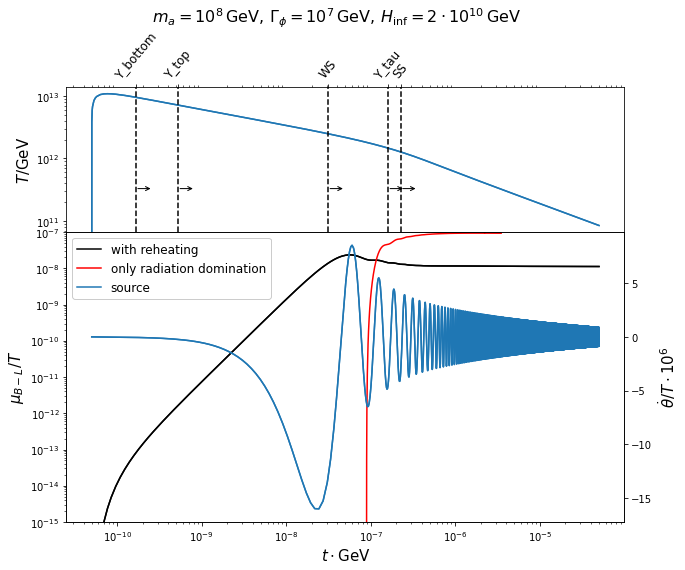

<ipython-input-5-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6
<ipython-input-5-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


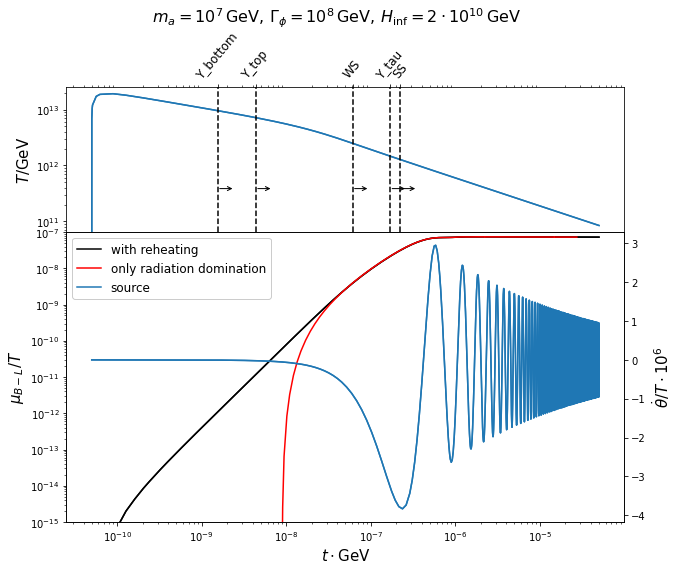

In [15]:
sim_and_plot(1e7, 1e8, H_inf, f_a)

<ipython-input-7-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6
<ipython-input-7-1f0733f58259>:24: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


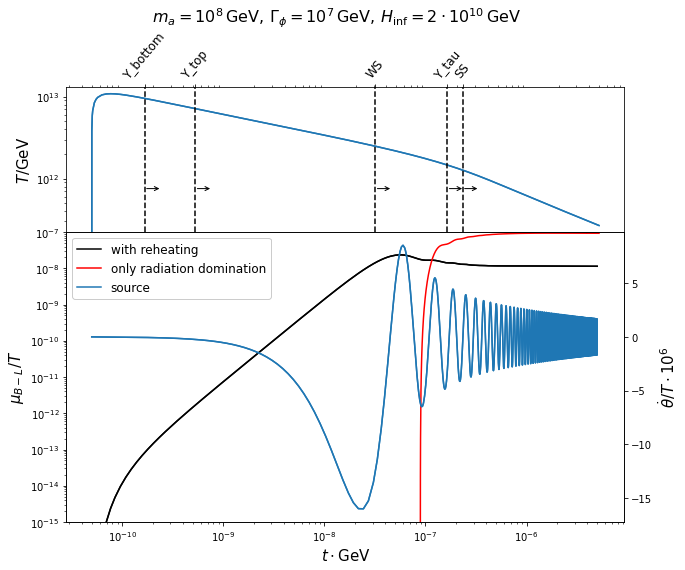

CPU times: user 8.63 s, sys: 40 ms, total: 8.67 s
Wall time: 8.45 s


In [15]:
%time (m1, m2), (r1, r2) = sim_and_plot(1e8, 1e7, H_inf, f_a, t_end=5e-6, T_end=3e11)

In [17]:
import axion_decay

In [18]:
axion_decay.compute_axion_decay

<function axion_decay.compute_axion_decay(T_start, red_chem_B_minus_L, theta, theta_dot, m_a, f_a, axion_decay_rate)>

In [80]:
# with reheating
m_a = m1.axion_parameter[0]
f_a_range = np.geomspace(1e11, 1e17, 40)
decay_rate = calc_Gamma_a_SU2(m_a, f_a)
r = r1[-1]
rh = [axion_decay.compute_axion_decay(r.T_fn(r.t[-1]), r.red_chem_B_minus_L[-1], *r.axion_fn(np.log(r.t[-1])), m_a, f_a, decay_rate) for f_a in f_a_range]

/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:8: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


In [81]:
# radiation domaination 
r = r2[-1]
rad = [axion_decay.compute_axion_decay(r.T[-1], r.red_chem_B_minus_L[-1], *r.axion.T[-1], m_a, f_a, decay_rate) for f_a in f_a_range]

In [87]:
f_a = 1e16

r = r1[-1]
T_rh = r.T_fn(r.t[-1])
rho_a_rh = np.sum(0.5 * f_a**2 * r.axion_fn(np.log(r.t[-1]))**2 * [m_a**2, 1])

r = r2[-1]
T_rad = r.T[-1]
rho_a_rad = np.sum(0.5 * f_a**2 * r.axion.T[-1]**2 * [m_a**2, 1]) # for the last f_A

In [107]:
def solve_decay(T, rho_a):
    domain = np.log((cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))),
                        30 / decay_rate))
    R0 = 1
    intitial = np.log((cosmology.calc_radiation_energy_density(T), rho_a, R0))
    sol = solve_ivp(axion_decay.rhs_axion_decay, domain, intitial, args=(decay_rate,))
    return sol
    #rho_R, rho_a, R = np.exp(sol.y)
    #current = (R0 / R)**3 * 
    #T = cosmology.calc_temperature(rho_R)
    #n_gamma = cosmology.calc_photon_number_density(T)

In [108]:
s_rad = solve_decay(T_rad, rho_a_rad)
s_rh = solve_decay(T_rh, rho_a_rh)

/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
/home/jana/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:8: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


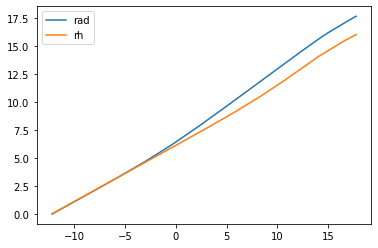

In [111]:
plt.plot(s_rad.t, s_rad.y[2], label="rad")
plt.plot(s_rh.t, s_rh.y[2], label="rh")
plt.legend()

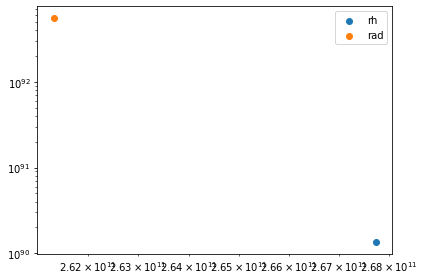

In [86]:
plt.scatter([T_rh], [rho_a_rh], label="rh")
plt.scatter([T_rad], [rho_a_rad], label="rad")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.tight_layout()

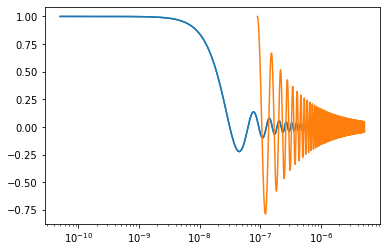

In [119]:
for r in r1:
    plt.semilogx(r.t, r.axion_fn(np.log(r.t))[0], color="tab:blue")
for r in r2:
    t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(r.T)))
    plt.semilogx(t, r.axion[0], color="tab:orange")

Text(0, 0.5, 'eta_B after axion decay')

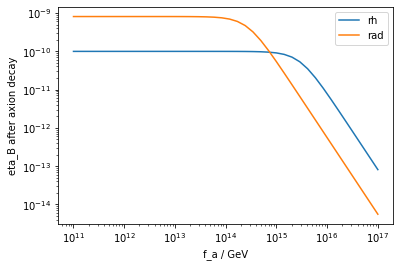

In [59]:
plt.loglog(f_a_range, rh, label="rh")
plt.loglog(f_a_range, rad, label="rad")
plt.legend()
plt.xlabel("f_a / GeV")
plt.ylabel("eta_B after axion decay")

# Plot of the Parameter Space

In [36]:
m_a_range = np.geomspace(1e6, 1e9, 11)
Gamma_phi_range = np.geomspace(1e6, 1e9, 10)

In [37]:
%%time
eta_B_rh = [[model.solve(model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                                           axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), 
                                                      (m_a,), Gamma_phi, H_inf),
                              (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

CPU times: user 5min 53s, sys: 49.4 ms, total: 5min 53s
Wall time: 5min 53s


In [41]:
%%time
eta_B_rad_dom = [[rad_dom_model.solve(rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                                                      rad_dom_axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), 
                                                                           (m_a,)), 
                                 cosmology.calc_reheating_temperature(Gamma_phi), (1,0), f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
                for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

../transport_eq/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)


CPU times: user 3min 49s, sys: 15.9 ms, total: 3min 49s
Wall time: 3min 49s


In [39]:
%%time
eta_B_original = [[original_model.compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

CPU times: user 14.6 s, sys: 3.99 ms, total: 14.7 s
Wall time: 14.7 s


In [26]:
fname = "background_cosmology_comparison.pkl"
#util.save_data(fname, m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh)
#m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh = util.load_data(fname)

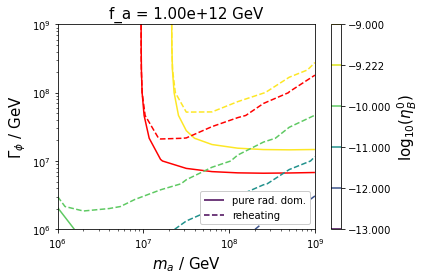

In [43]:
levels = np.hstack([np.arange(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
          1), np.log10(constants.eta_B_observed)])
levels.sort()

#levels = np.hstack([np.linspace(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
#          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
#          10), np.log10(constants.eta_B_observed)])
#levels.sort()

CS = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rad_dom), levels
                )
plt.colorbar().set_label(r"$\log_{10} (\eta_B^0)$", fontsize=15)
CS.collections[np.where(CS.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS2 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rh), levels, 
                  linestyles="--")
CS2.collections[np.where(CS2.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

#CS3 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_original), levels, linestyles=":")
#CS3.collections[np.where(CS3.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

plt.title(f"f_a = {f_a:.2e} GeV", fontsize=15)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("$m_a$ / GeV", fontsize=15)
plt.ylabel(r"$\Gamma_\phi$ / GeV", fontsize=15)
h1, _ = CS.legend_elements()
h2, _ = CS2.legend_elements()
#h3, _ = CS3.legend_elements()
#plt.legend([h1[0], h2[0], h3[0]], ["pure rad. dom.", "reheating", "original"], framealpha=1.0, loc=4)
plt.legend([h1[0], h2[0]], ["pure rad. dom.", "reheating"], framealpha=1.0, loc=4)

plt.tight_layout()
# plt.savefig(util.make_plot_path("rad_dom_vs_rh_parameter_space.pdf"))